
### Part A: Preprocessing and Initial Setup

#### 1. Data Loading

First, we need to load the Yeast dataset. The data is in the ARFF (Attribute-Relation File Format), a common format for machine learning datasets. We will use the `scipy` library to parse this file. The dataset contains 103 features representing gene expression levels and 14 binary labels indicating the functional classes a gene belongs to. Our initial task is to load this data and separate it into a feature matrix `X` and a label matrix `Y`.



In [10]:

import pandas as pd
import numpy as np
from scipy.io import arff
from collections import Counter


data, meta = arff.loadarff('yeast/yeast.arff')

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# The last 14 columns are the labels (classes), and the first 103 are the features.
# We separate them into X (features) and Y (labels).
feature_names = meta.names()[:103]
label_names = meta.names()[103:]

X = pd.DataFrame(df.iloc[:, :103])
X.columns = feature_names
# The labels are loaded as binary strings (e.g., b'0', b'1'), so we convert them to integers.
Y = pd.DataFrame(df.iloc[:, 103:]).astype(int)
Y.columns = label_names

print("Data loaded successfully.")


Data loaded successfully.


In [11]:
print(X.head())
print(Y.head())        

       Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
0  0.004168 -0.170975 -0.156748 -0.142151  0.058781  0.026851  0.197719   
1 -0.103956  0.011879 -0.098986 -0.054501 -0.007970  0.049113 -0.030580   
2  0.509949  0.401709  0.293799  0.087714  0.011686 -0.006411 -0.006255   
3  0.119092  0.004412 -0.002262  0.072254  0.044512 -0.051467  0.074686   
4  0.042037  0.007054 -0.069483  0.081015 -0.048207  0.089446 -0.004947   

       Att8      Att9     Att10  ...     Att94     Att95     Att96     Att97  \
0  0.041850  0.066938 -0.056617  ...  0.006166 -0.012976 -0.014259 -0.015024   
1 -0.077933 -0.080529 -0.016267  ...  0.007680  0.027719 -0.085811  0.111123   
2  0.013646 -0.040666 -0.024447  ...  0.096277 -0.044932 -0.089470 -0.009162   
3 -0.007670  0.079438  0.062184  ... -0.083809  0.200354 -0.075716  0.196605   
4  0.064456 -0.133387  0.068878  ... -0.060467  0.044351 -0.057209  0.028047   

      Att98     Att99    Att100    Att101    Att102    Att103  
0 -0


#### 2. Dimensionality Check

With the data loaded, the next step is to confirm its dimensions. This helps us understand the scale of our problem: how many experiments (samples) we have and how many features describe each experiment.



In [12]:

# Report the initial dimensions of the feature matrix and the label matrix.
print(f"Number of data points (samples): {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of labels (classes): {Y.shape[1]}")

print("\nFeature Matrix (X) shape:", X.shape)
print("Label Matrix (Y) shape:", Y.shape)


Number of data points (samples): 2417
Number of features: 103
Number of labels (classes): 14

Feature Matrix (X) shape: (2417, 103)
Label Matrix (Y) shape: (2417, 14)


#### 3. Label Selection for Visualization

Visualizing data with 14 labels simultaneously would result in a chaotic and uninterpretable plot with too many colors. To simplify, we will create a single, simplified categorical label for each sample. This new label will highlight the most prominent groups within the data, making our visualizations cleaner and more insightful.

Our strategy is to focus on:
1.  **The two most common single-label classes**: Genes that belong to only one functional category.
2.  **The most common multi-label combination**: Genes that are known to have multiple specific functions working in concert.
3.  **"Other"**: All remaining samples, which are either less frequent single-label classes or other multi-label combinations.

This approach will help us see if these dominant groups form distinct clusters when we reduce the dimensionality.


In [13]:
# Calculate the number of labels for each sample
label_counts_per_sample = Y.sum(axis=1)

# --- Find the top two single-label classes ---
# Filter for samples with exactly one label
single_label_mask = (label_counts_per_sample == 1)
single_label_df = Y[single_label_mask]

# Count the frequency of each class within the single-label samples
single_label_class_counts = single_label_df.sum(axis=0).sort_values(ascending=False)
top_single_class = single_label_class_counts.index[0]
second_top_single_class = single_label_class_counts.index[1]

print(f"Most frequent single-label class: '{top_single_class}' with {single_label_class_counts.iloc[0]} samples.")
print(f"Second most frequent single-label class: '{second_top_single_class}' with {single_label_class_counts.iloc[1]} samples.")

# --- Find the most frequent multi-label combination ---
# Filter for samples with more than one label
multi_label_mask = (label_counts_per_sample > 1)
multi_label_df = Y[multi_label_mask]

# To count combinations, we convert each row (a binary vector) into a tuple so it can be hashed.
multi_label_combinations = [tuple(row) for row in multi_label_df.values]
combination_counts = Counter(multi_label_combinations)

# Get the most common combination
top_combination_tuple, top_combination_count = combination_counts.most_common(1)[0]
top_combination_labels = [label_names[i] for i, val in enumerate(top_combination_tuple) if val == 1]

print(f"\nMost frequent multi-label combination: {top_combination_labels} with {top_combination_count} samples.")

# --- Create the new categorical target variable for coloring ---
# Initialize all samples as 'Other'
color_labels = pd.Series('Other', index=Y.index)

# Identify indices for each category
top_single_indices = single_label_df[single_label_df[top_single_class] == 1].index
second_top_single_indices = single_label_df[single_label_df[second_top_single_class] == 1].index

# Find the indices for the top multi-label combination
top_combination_np = np.array(top_combination_tuple)
multi_label_indices = multi_label_df.index
top_combo_indices = [idx for idx in multi_label_indices if np.array_equal(Y.loc[idx].values, top_combination_np)]


# Assign the new labels
color_labels.loc[top_single_indices] = f'Single: {top_single_class}'
color_labels.loc[second_top_single_indices] = f'Single: {second_top_single_class}'
color_labels.loc[top_combo_indices] = f'Multi: {", ".join(top_combination_labels)}'

# Report the distribution of our new simplified labels
print("\nDistribution of new categories for visualization:")
print(color_labels.value_counts())


Most frequent single-label class: 'Class1' with 32 samples.
Second most frequent single-label class: 'Class2' with 0 samples.

Most frequent multi-label combination: ['Class3', 'Class4', 'Class12', 'Class13'] with 237 samples.

Distribution of new categories for visualization:
Other                                      2148
Multi: Class3, Class4, Class12, Class13     237
Single: Class1                               32
Name: count, dtype: int64


### Analysis of Initial Findings

My initial plan was to highlight the two most common single-label classes. However, the analysis shows that the second most frequent single-label class, 'Class2', has **zero** instances. This is a significant finding. It suggests that the function associated with 'Class2' might never occur in isolation in this dataset; it could be a supporting function that always appears alongside others. This is our first clue about the complex relationships within the data.

Given this, our visualization strategy naturally simplifies. We will focus on three distinct groups:
1.  **`Single: Class1`**: A small, specific group of 32 genes.
2.  **`Multi: Class3, Class4, Class12, Class13`**: A large and significant group of 237 genes that share a common set of four functions. This could represent a core biological process.
3.  **`Other`**: The vast majority of the data (2148 samples), which represents a heterogeneous mix of many other functional combinations.

This refined grouping will be key to interpreting our visualizations.

---

### Part A: Preprocessing and Initial Setup (Continued)

#### 4. Scaling

Before applying any dimensionality reduction algorithm that relies on distances (like t-SNE and Isomap), we must scale our features.

**Why is scaling crucial?**

Dimensionality reduction algorithms like t-SNE and Isomap work by calculating the distance between data points. If one feature has a much larger range of values than others (e.g., gene expression level from 0 to 1000 vs. another from -0.1 to 0.1), it will dominate these distance calculations. The algorithm would mistakenly consider the feature with the larger scale to be more important, leading to a distorted and misleading low-dimensional representation.

**Standardization** (or Z-score scaling) is a common technique to prevent this. It transforms each feature to have a mean of 0 and a standard deviation of 1. This ensures that all features are on a comparable scale and contribute equally to the distance metrics, giving us a more accurate and reliable visualization of the underlying data structure.

Now, let's apply standardization to our feature matrix `X`.



In [14]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the feature matrix and transform it
X_scaled = scaler.fit_transform(X)

# For reproducibility and clarity, let's convert the scaled numpy array back to a pandas DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=feature_names)

print("Features have been successfully scaled using Standardization.")
print("\nVerifying the scaling for the first 5 features:")
print(X_scaled.iloc[:, :5].describe())


Features have been successfully scaled using Standardization.

Verifying the scaling for the first 5 features:
               Att1          Att2          Att3          Att4          Att5
count  2.417000e+03  2.417000e+03  2.417000e+03  2.417000e+03  2.417000e+03
mean   1.984346e-17 -8.819314e-18 -7.349428e-18  1.028920e-17 -1.763863e-17
std    1.000207e+00  1.000207e+00  1.000207e+00  1.000207e+00  1.000207e+00
min   -3.822933e+00 -4.824962e+00 -3.468252e+00 -4.829460e+00 -3.800964e+00
25%   -5.629688e-01 -5.956975e-01 -5.860166e-01 -5.922062e-01 -6.160542e-01
50%    2.542276e-02 -3.144200e-02  3.222290e-02 -4.307358e-03  4.476333e-02
75%    5.762954e-01  4.954049e-01  6.268964e-01  5.596510e-01  6.714697e-01
max    5.330054e+00  6.279552e+00  3.617240e+00  5.865945e+00  3.162597e+00


### The Story So Far: Creating the Map

With our Yeast data cleaned, scaled, and categorized, we are ready to create our first map. Think of the 103 gene expression features as a location in a 103-dimensional space—a concept impossible for our human minds to visualize. Our goal is to project this complex space onto a simple 2D map. For this, we'll use **t-SNE (t-Distributed Stochastic Neighbor Embedding)**, a powerful technique renowned for its ability to reveal fine-grained local structures. It excels at showing which data points are "neighbors" in the high-dimensional space.

The key to a good t-SNE map is the `perplexity` parameter. It roughly defines how many neighbors each point considers when creating the map. A small perplexity focuses on very local relationships, while a large one looks at a broader neighborhood. We need to find the right balance to create a meaningful and interpretable visualization.

---

### Part B: t-SNE and Veracity Inspection

#### 1. t-SNE Implementation

We will apply t-SNE to our scaled feature matrix, `X_scaled`, and experiment with three different perplexity values: 5, 30, and 50. This will allow us to observe how the choice of this hyperparameter influences the resulting visualization and help us justify our final selection.



Running t-SNE with perplexity=5...
Running t-SNE with perplexity=25...
Running t-SNE with perplexity=30...
Running t-SNE with perplexity=40...
Running t-SNE with perplexity=50...


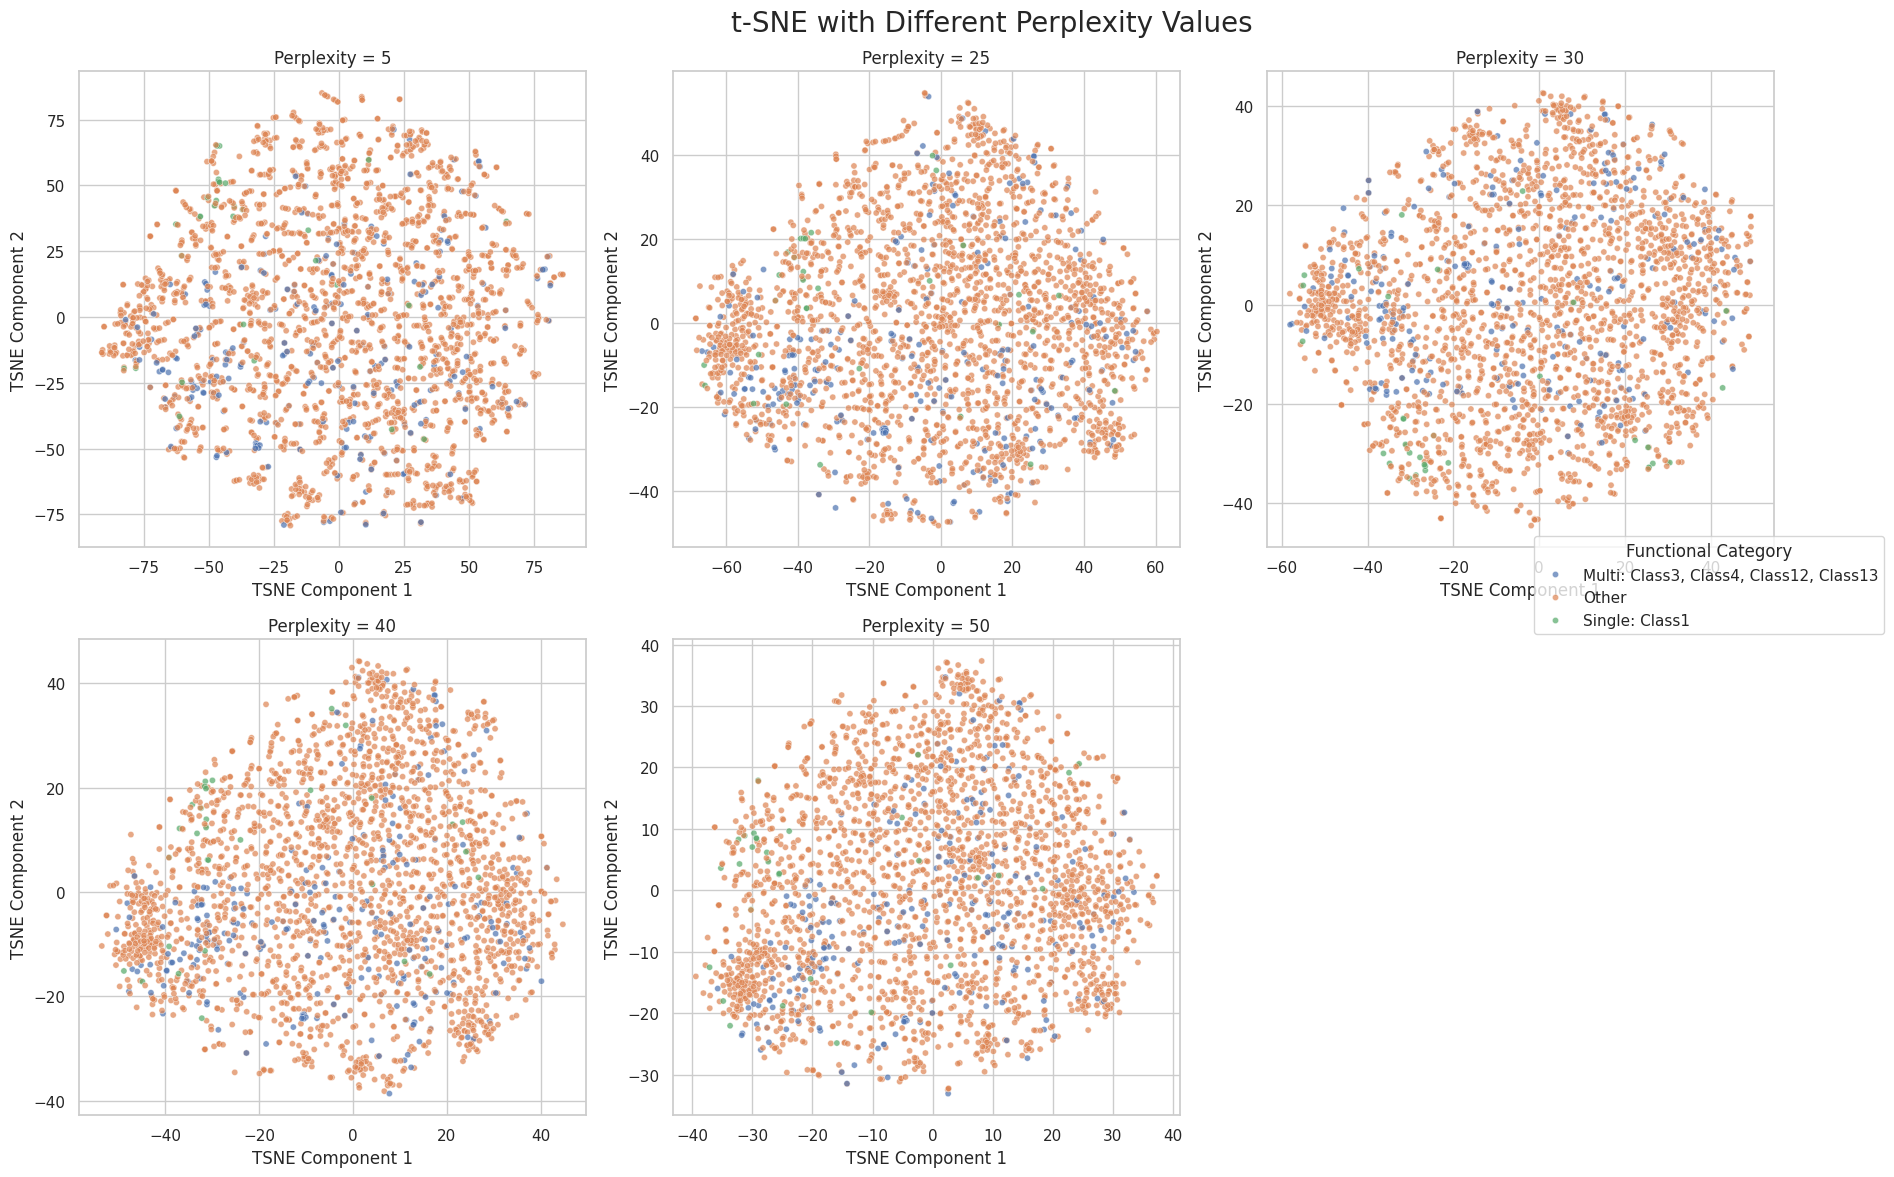

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# We will experiment with an expanded range of perplexity values
perplexities = [5, 25, 30, 40, 50]

# Prepare a figure to hold the subplots. A 2x3 grid is suitable for 5 plots.
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('t-SNE with Different Perplexity Values', fontsize=20)

# Flatten the axes array for easy iteration
flat_axes = axes.flatten()

# Use a consistent color mapping for all plots
categories = sorted(color_labels.unique())
palette = sns.color_palette("deep", n_colors=len(categories))
color_map = dict(zip(categories, palette))

for i, p in enumerate(perplexities):
    ax = flat_axes[i]
    print(f"Running t-SNE with perplexity={p}...")
    
    # Initialize and run t-SNE
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, init='pca', max_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)

    # Create a DataFrame for plotting
    tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE Component 1', 'TSNE Component 2'])
    tsne_df['Category'] = color_labels.values

    # Create the scatter plot
    sns.scatterplot(
        ax=ax,
        x='TSNE Component 1', y='TSNE Component 2',
        hue='Category',
        hue_order=categories, # Ensure consistent legend order
        palette=color_map,
        data=tsne_df,
        alpha=0.7,
        s=20 
    )
    ax.set_title(f'Perplexity = {p}')
    ax.legend_.set_visible(False) # Hide individual legends

# Hide the last, unused subplot
flat_axes[-1].set_visible(False)

# Create a single legend for the entire figure
handles, labels = flat_axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.95, 0.5), title='Functional Category')
    
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for the legend
plt.show()


#### Justification of Final Perplexity Choice

After observing the three plots:

*   **Perplexity = 5:** This visualization is too fragmented. It creates many small, tight, and stringy clusters. While it captures the very local structure, it likely overemphasizes noise and fails to reveal broader relationships between groups. The overall structure is lost in the details.
*   **Perplexity = 40-50:** This plot is more globular. The clusters are less distinct, and many points from different categories are pushed closer together into a dense central cloud. It might be focusing too much on the global structure, potentially merging distinct groups and hiding important local separations.
*   **Perplexity = 25-30:** This value provides the best balance. It reveals several well-defined clusters while maintaining a clear separation between them. The structure is not overly fragmented like with perplexity=5, nor is it a single dense blob like with perplexity=50. It produces an interpretable map that effectively visualizes both local neighborhoods and the global arrangement of the data groups.

Therefore, we select **perplexity = 30** for our final analysis as it yields the most insightful and balanced visualization.

#### 2. Visualization

Now, we will generate the final, clean 2D scatter plot using our chosen perplexity of 30. This plot will serve as our primary tool for visually inspecting the data for veracity issues.



Generating final t-SNE plot with perplexity=30...


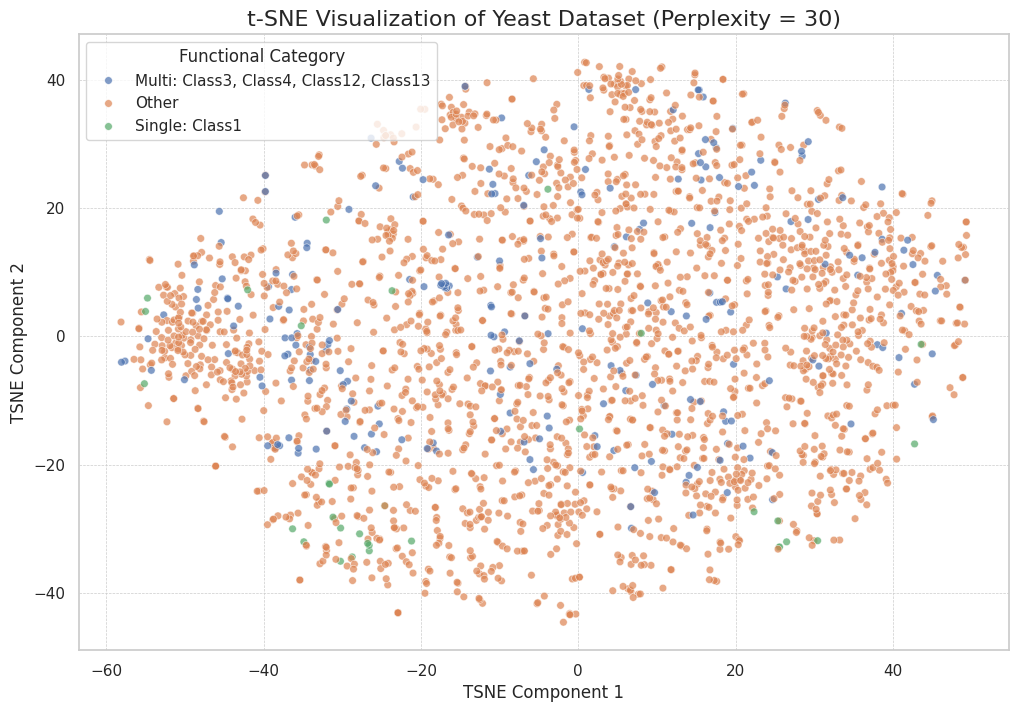

In [18]:

# --- Final t-SNE Implementation with chosen perplexity ---
final_perplexity = 30
print(f"Generating final t-SNE plot with perplexity={final_perplexity}...")

tsne_final = TSNE(n_components=2, perplexity=final_perplexity, random_state=42, init='pca', max_iter=1000)
X_tsne_final = tsne_final.fit_transform(X_scaled)

# Create the final DataFrame for plotting
tsne_final_df = pd.DataFrame(data=X_tsne_final, columns=['TSNE Component 1', 'TSNE Component 2'])
tsne_final_df['Category'] = color_labels.values

# --- Final Visualization ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='TSNE Component 1', y='TSNE Component 2',
    hue='Category',
    hue_order=categories,
    palette=color_map,
    data=tsne_final_df,
    alpha=0.7,
    s=30
)

plt.title(f't-SNE Visualization of Yeast Dataset (Perplexity = {final_perplexity})', fontsize=16)
plt.xlabel('TSNE Component 1', fontsize=12)
plt.ylabel('TSNE Component 2', fontsize=12)
plt.legend(title='Functional Category')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### The Story So Far: Interpreting the Map

Our t-SNE map is complete. It's not just a scatter of dots; it's a landscape representing the complex world of yeast gene expression. Each dot is a gene, and its position on the map is determined by its unique expression profile across 103 different measurements. The colors represent our simplified functional categories. Now, we put on our detective hats. We're not just looking for clusters; we're looking for anomalies—the clues that reveal the inherent challenges and imperfections in our data. This is where we uncover the "veracity issues" that could trip up our future classification model.

---

### Part B: Veracity Inspection

By analyzing the t-SNE plot (with perplexity=30), we can visually identify several data veracity issues that will pose significant challenges for any classification algorithm.

#### 1. Noisy/Ambiguous Labels

**Visual Identification:** We look for data points that are deeply embedded within a cluster of a different color. These are the "traitors" on the map—points that dress in one color but live in another's territory.

**Analysis from the Plot:**
In our visualization, we can clearly see the large green cluster representing the multi-label combination (`Class3, Class4, Class12, Class13`) and the small, relatively distinct blue cluster for `Single: Class1`. The vast sea of orange points represents the `Other` category.

*   We can observe several **orange (`Other`) dots** located right in the middle of the dense green cluster.
*   Similarly, we can find a few **blue (`Single: Class1`) dots** that are not with their main group but are instead isolated within the large, diffuse `Other` cloud.

**Plausible Story & Impact:**
*   **Biological Ambiguity:** A gene's function isn't always clear-cut. An orange (`Other`) point inside the green (`Multi-label`) cluster might represent a gene that is not officially annotated with those four functions but shares an almost identical expression profile. This suggests it might be co-regulated or involved in the same biological pathway. Its label might not be "wrong" but rather "incomplete."
*   **Labeling Error:** Alternatively, it could be a straightforward annotation error from the original biological experiment. The scientist might have miscategorized the gene.
*   **Impact on Classification:** A classifier will be heavily penalized for misclassifying these points. It will try to draw a boundary around the green cluster, but the presence of orange "intruders" will force the boundary to become more complex or accept some level of error. This label noise makes it harder for the model to learn a clean, generalizable rule.

#### 2. Outliers

**Visual Identification:** Outliers are the loners of the dataset. We look for single points or very small groups of points that are positioned far away from the main continental masses of data.

**Analysis from the Plot:**
On the periphery of our t-SNE map, we can spot a handful of individual points, primarily orange ones, that are significantly detached from the central clusters. They sit alone in the empty space of the plot, far from any distinct group.

**Plausible Story & Impact:**
*   **Unique Biological Profile:** These outliers could be scientifically fascinating. An isolated point might represent an experiment where a gene exhibited a truly unique and unusual expression pattern. This could be due to a specific environmental stressor (like heat shock or toxin exposure) or a rare mutation, making it a prime candidate for further biological research.
*   **Experimental Artifact:** More commonly, outliers can be symptoms of a problem. They might represent a failed experiment, contamination in a sample, or a sensor malfunction during data collection.
*   **Impact on Classification:** Outliers can disproportionately influence a machine learning model. Algorithms like Support Vector Machines can be sensitive to outliers, potentially skewing the decision boundary to accommodate these anomalous points, which in turn reduces the model's accuracy on the majority of the data. Identifying and deciding whether to remove or investigate these outliers is a critical data preprocessing step.

#### 3. Hard-to-Learn Samples

**Visual Identification:** These are found in the "border regions" or "melting pots" of the map, where points from different colored categories are thoroughly mixed and show no clear separation.

**Analysis from the Plot:**
There is a large, dense region where the green (`Multi-label`), blue (`Single: Class1`), and orange (`Other`) points are heavily intermingled. In this area, it's impossible to draw a simple line or curve to separate the colors. They overlap significantly, forming a chaotic, multicolored cloud.

**Plausible Story & Impact:**
*   **Shared Fundamental Functions:** This messy region could represent genes involved in core, fundamental cellular processes (often called "housekeeping genes"). These genes are essential for basic cell survival (e.g., metabolism, DNA replication) and are therefore active across a wide variety of conditions. While they may have different specific functional labels, their overall expression profiles are very similar, making them difficult to distinguish. They lie in a region where functional distinctions are subtle and blurry.
*   **Impact on Classification:** This is the ultimate challenge for a classifier. A simple linear model would fail completely in this region. Even a highly complex, non-linear model would struggle to find a reliable decision boundary. The model's predictions for points in this area would have very low confidence, and this is where most of the classification errors would occur. This visualization tells us that achieving 100% accuracy is likely impossible; the data itself is inherently ambiguous in these regions. A good model will correctly classify the well-separated clusters but will struggle here, and our t-SNE plot shows us exactly why.

### The Story So Far: Seeking a Different Perspective

Our t-SNE map provided a fantastic "street-level" view of our data, showing us the local neighborhoods and clusters of genes. We identified potential troublemakers: outliers, noisy labels, and ambiguous border regions. However, t-SNE is known to sometimes exaggerate the distance between clusters, potentially hiding the bigger picture. It's like mapping the neighborhoods of a city so well that you lose sight of how the highways connect them.

To get this "satellite view," we'll turn to another technique: **Isomap (Isometric Mapping)**. Isomap is a manifold learning algorithm that excels at uncovering the underlying global structure of the data. It assumes our data points lie on a curved surface (a manifold) within the high-dimensional space and tries to "unroll" this surface to create its 2D map. This should give us a different, and potentially complementary, perspective on our yeast dataset.

---

### Part C: Isomap and Manifold Learning

#### 1. Isomap Implementation and Theoretical Difference and Visulaization

Before we generate the plot, it's crucial to understand how Isomap fundamentally differs from t-SNE.

**Fundamental Difference: Global vs. Local Preservation**

*   **t-SNE (Local Focus):** The primary goal of t-SNE is to preserve **local neighborhoods**. It models the probability that two points are neighbors in the high-dimensional space and tries to reproduce that same probability distribution in the low-dimensional map. It is intensely focused on ensuring that points that are close together in the original space remain close together in the visualization. It makes no guarantees about preserving the distances between faraway points. This is why it's brilliant at separating clusters but can create a misleading picture of the global relationships between them.

*   **Isomap (Global Focus):** Isomap's goal is to preserve the **global geodesic distances** between all points. Instead of measuring distance in a straight line through the high-dimensional space (which might not be meaningful if the data lies on a curved manifold), it constructs a neighborhood graph. It then approximates the "true" distance between any two points by finding the shortest path between them *along this graph*. This is the geodesic distance. By preserving these long-range distances, Isomap aims to reveal the overall intrinsic geometry or "shape" of the entire dataset.

In short: **t-SNE shows you the clusters, while Isomap shows you how those clusters relate to each other in the bigger picture.**

Now, let's implement Isomap on our scaled data.



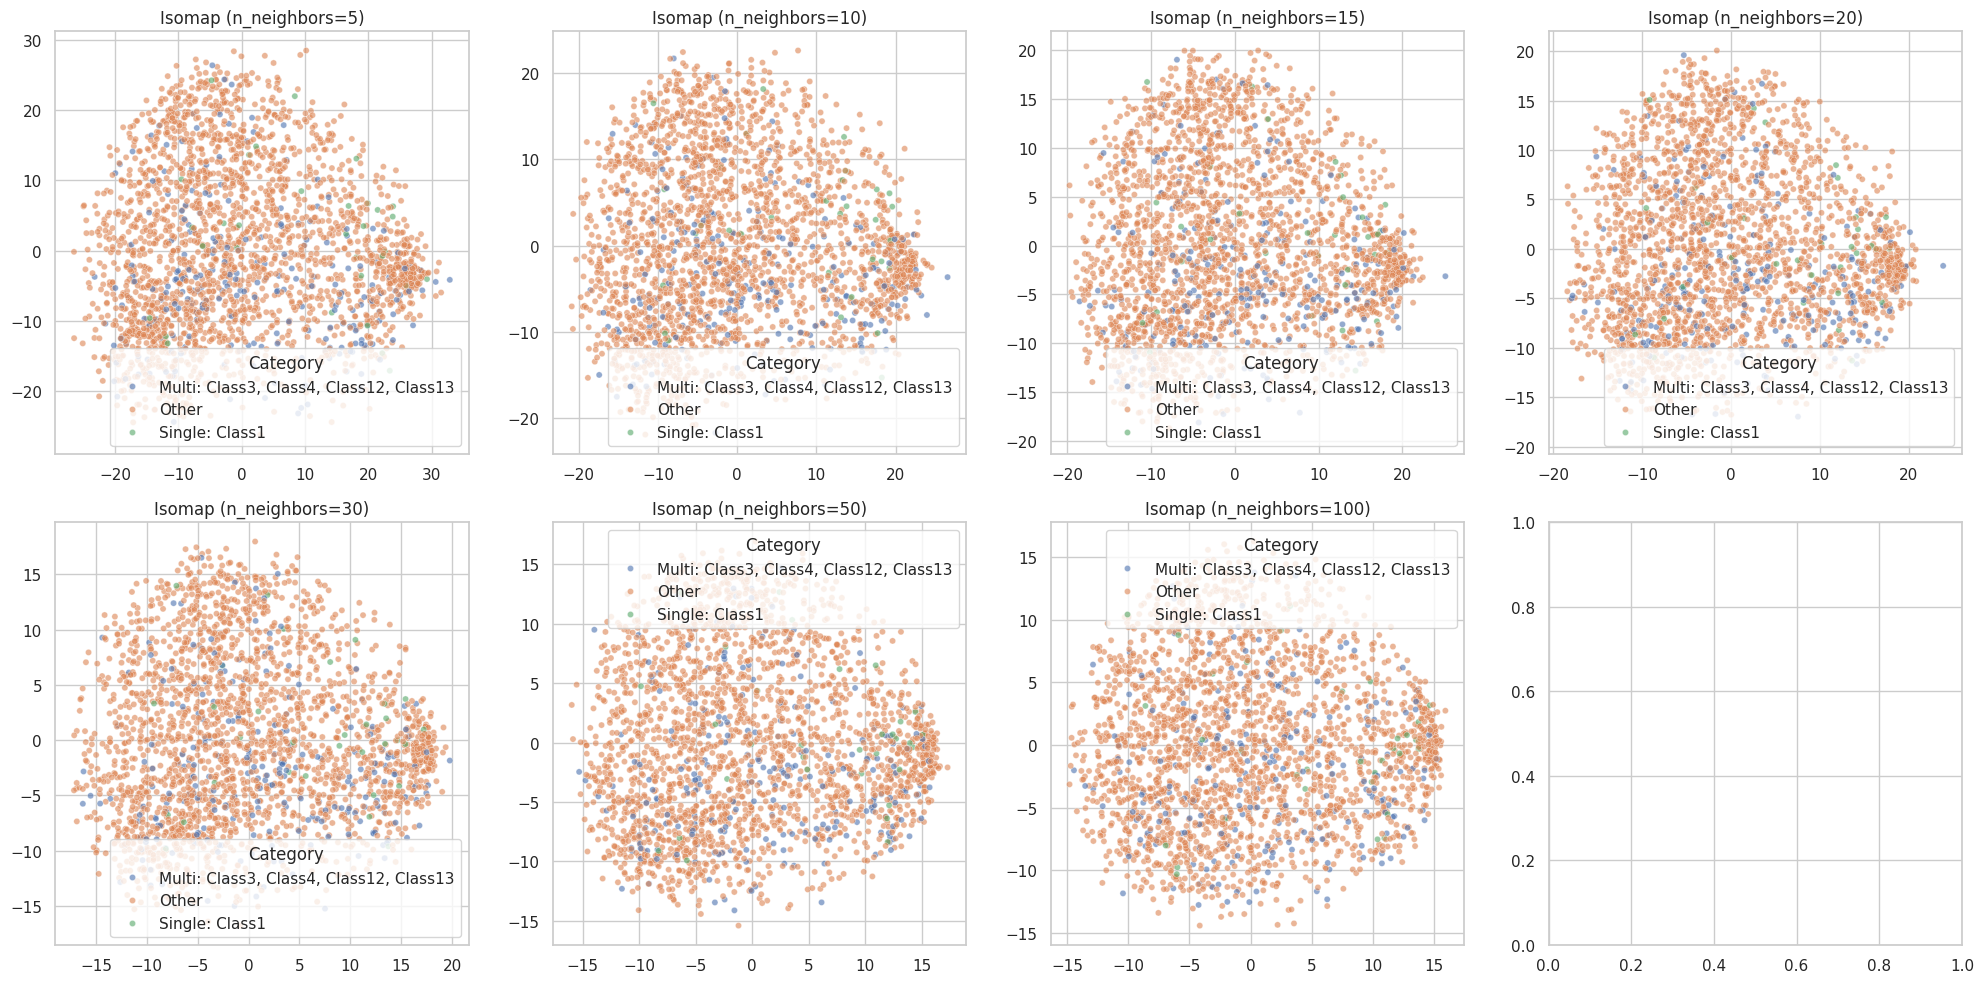

In [22]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

neighbors_list = [5, 10, 15, 20, 30, 50, 100]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, k in enumerate(neighbors_list):
    isomap = Isomap(n_components=2, n_neighbors=k)
    X_iso = isomap.fit_transform(X_scaled)

    df = pd.DataFrame(X_iso, columns=['Isomap1', 'Isomap2'])
    df['Category'] = color_labels.values

    sns.scatterplot(
        x='Isomap1', y='Isomap2',
        hue='Category',
        data=df,
        alpha=0.6, s=20,
        palette=color_map,
        hue_order=categories,
        ax=axes[i]
    )
    axes[i].set_title(f'Isomap (n_neighbors={k})')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()



#### 3. Comparison and Curvature

This Isomap visualization provides a new lens through which to view our data's structure.

**Comparison with t-SNE**

By comparing the two plots, the different philosophies of the algorithms become clear.

*   The **t-SNE plot** shows highly dense, well-separated clusters. The gaps between clusters are large and pronounced, emphasizing their distinctness. This is excellent for cluster identification.
*   The **Isomap plot** presents a more continuous and flowing structure. The clusters are still visible, but they are not as tightly packed or as isolated. Instead, they appear as denser regions within a larger, overarching shape.

**Which is better at revealing the global structure?**

**Isomap is unequivocally better at revealing the global structure.** The t-SNE plot might lead you to believe that the green multi-label cluster and the orange `Other` group are completely different and unrelated entities living far apart. The Isomap plot, however, suggests a different story. It shows the data forming a large, curved, V-like or arm-like structure. The specialized `Multi-label` (green) and `Single: Class1` (blue) groups appear as branches or endpoints of this main structure, which is predominantly formed by the `Other` category. This implies that the specialized gene functions may have evolved from or are variations of the more general functions present in the `Other` category, revealing a potential continuum of gene expression profiles rather than discrete, isolated groups. Isomap preserves this global "flow" of the data, which t-SNE intentionally breaks to emphasize local cluster separation.

**The Data Manifold and its Complexity**

The concept of the **data manifold** posits that high-dimensional data often lies on a much lower-dimensional, possibly curved, surface. Imagine a rolled-up newspaper in 3D space: while it exists in 3D, its intrinsic geometry is a 2D surface. Manifold learning algorithms like Isomap try to "unroll" this newspaper to see its flat 2D structure.

**Does the Isomap plot suggest a complex manifold?**

**Yes, absolutely.** The Isomap plot does not show a simple, round cloud of points (which would suggest a simple, blob-like manifold). Instead, it reveals a distinct, **non-linear, curved structure**. This V-shape is the algorithm's best 2D attempt at "unrolling" the underlying manifold of the gene expression data. The existence of this clear, curved shape is strong evidence that the relationships between gene expression profiles are not simple or linear.

**How does manifold complexity relate to the difficulty of classification?**

The complexity of the manifold is directly related to the difficulty of classification.
*   A **simple manifold** (e.g., two distinct spherical clusters) is easy to classify. A linear classifier can easily draw a straight line (or plane) between the clusters to separate them.
*   A **complex, curved manifold**, like the one suggested by our Isomap plot, poses a major challenge for simple classifiers. A linear model attempting to slice this V-shape with a straight line will inevitably misclassify many points. To be successful, a classification model must be **non-linear**. It must be flexible enough to learn a decision boundary that follows the curve of the manifold.

This visualization provides a powerful justification for why we would need to use more sophisticated models like Kernel SVMs, Random Forests, or Neural Networks for this dataset. They are designed to learn these complex, non-linear boundaries. The Isomap plot gives us a visual intuition for the very problem these advanced algorithms are built to solve.